In [1]:
import sys, os
import pandas as pd
import numpy as np
import warnings

seed = 42

#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.set_random_seed(seed)
#tf.random.set_seed(seed)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
filename = os.path.expanduser('~')+'/Machine Learning 2019-2020 Winter/SUSY.csv'

columns = ['signal', 'lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT',
          'lepton 2 eta', 'lepton 2 phi', 'missing energy magnitude', 'missing energy phi',
           'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b',
           'cos(theta_r1)']

df_train = pd.read_csv(filename, names=columns, nrows=1500000, engine='python')
df_test = pd.read_csv(filename, names=columns, nrows=500000, skiprows=1500000, engine='python')


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys

def getTrainData(nVar):
    designMatrix = df_train.iloc[:,1:nVar+1].values
    labels       = df_train['signal'].values
    return (designMatrix, labels)

def getTestData(nVar):
    designMatrix = df_test.iloc[:,1:nVar+1].values
    labels       = df_test['signal'].values
    return (designMatrix, labels)

def build_roc_curve(probs, signal_bit, threshes):
    signal_probs = pd.Series(probs[:,1])
    signal_true  = pd.Series(signal_bit)
    signal_df    = pd.DataFrame(signal_probs, columns=['sig_prob'])
    signal_df.loc[:,'sig_true'] = signal_true
    Acceptance   = []
    Rejection    = []
    
    for thresh in threshes:
        signal_df.loc[:,'accept'] = signal_df['sig_prob'] > thresh
        nSigCor  = len(signal_df[(signal_df['accept']) & (signal_df['sig_true']==1.)])
        nSig     = len(signal_df[signal_df['sig_true']==1.])
        nBkgCor  = len(signal_df[(signal_df['sig_true']==0.) & (~signal_df['accept'])])
        nBkg     = len(signal_df[signal_df['sig_true']==0.])
        Acceptance.append(nSigCor/nSig)
        Rejection.append(nBkgCor/nBkg)
    return Acceptance, Rejection

# define training algo. so we call it easily
def runTensorFlowRegression(nVar,alpha):
    # make data array placeholder for just first nVar=8 simple features
    x = tf.placeholder(tf.float32,[None, nVar])
    # make weight and bias
    W = tf.Variable(tf.zeros([nVar,2]))
    b = tf.Variable(tf.zeros([2]))
    
    y = tf.nn.softmax(tf.matmul(x,W)+b)
    # placeholder for correct answer
    y_ = tf.placeholder(tf.float32, [None, 2])
    # cross entropy with L1 regularizer
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y,labels=y_)+alpha*tf.nn.l2_loss(W))
    
    # define training step
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    # initialize variables
    init = tf.global_variables_initializer()
    # setup session
    sess = tf.Session()
    sess.run(init)
    
    Var_train, Sig_train_bit1 = getTrainData(nVar)
    
    Sig_train_bit0 = Sig_train_bit1.copy()
    Sig_train_bit0 = 1 - Sig_train_bit0
    Sig_train = np.column_stack((Sig_train_bit0, Sig_train_bit1))
    
    ##### ----- Training ----- #####
    # Perform minibatch gradient descent with minibatches with size 100:
    n_data = len(Sig_train_bit1)
    minibatch_size = 100
    n_minibatch = n_data//minibatch_size
    print ('\t Training with %i minibatches, dataset size is %i'%(n_minibatch, n_data))
    
    for i in range(0, n_minibatch):
        sys.stdout.write('%.3f %% completed \r'%(100*i/n_minibatch))
        sys.stdout.flush()
        start = i*minibatch_size
        end = (i+1)*minibatch_size-1
        
        batch_x = Var_train[start:end]
        batch_y = Sig_train[start:end]
        sess.run(train_step, feed_dict={x:batch_x, y_: batch_y})
        
    # Accuracy function
    correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    
    ##### ----- Testing ----- #####
    Var_test = df_test.iloc[:,1:nVar+1].values
    Sig_test_bit1 = df_test['signal'].values
    
    Sig_test_bit0 = Sig_test_bit1.copy()
    Sig_test_bit0 = 1 - Sig_test_bit1
    Sig_test = np.column_stack((Sig_test_bit0, Sig_test_bit1))
    
    print ('\t Accuracy for alpha %.1E : %.3f' %(alpha, sess.run(accuracy, feed_dict={x: Var_test, y_: Sig_test})))
    
    # Get the weights
    weights = W.eval(session=sess)
    # Get Probabilities assigned
    probs = y.eval(feed_dict = {x: Var_test}, session=sess)
    # Now get the signal efficiency and background rejection on the test data
    print('\t Computing ROV curve ...')
    # Build ROC curve by scanning over thresholds of probability of being
    # a background event and calculating signal efficiency/background rejection
    # at each threshold
    threshes = np.arange(0,1,0.01)
    Acceptance, Rejection = build_roc_curve(probs, Sig_test_bit1, threshes)
    
    return (probs, Acceptance, Rejection)
    


Training for alpha = 1.00E-10
	 Training with 15000 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-10 : 0.770
	 Computing ROV curve ...
Training for alpha = 7.94E-10
	 Training with 15000 minibatches, dataset size is 1500000
	 Accuracy for alpha 7.9E-10 : 0.770
	 Computing ROV curve ...
Training for alpha = 6.31E-09
	 Training with 15000 minibatches, dataset size is 1500000
	 Accuracy for alpha 6.3E-09 : 0.770
	 Computing ROV curve ...
Training for alpha = 5.01E-08
	 Training with 15000 minibatches, dataset size is 1500000
	 Accuracy for alpha 5.0E-08 : 0.770
	 Computing ROV curve ...
Training for alpha = 3.98E-07
	 Training with 15000 minibatches, dataset size is 1500000
	 Accuracy for alpha 4.0E-07 : 0.770
	 Computing ROV curve ...
Training for alpha = 3.16E-06
	 Training with 15000 minibatches, dataset size is 1500000
	 Accuracy for alpha 3.2E-06 : 0.770
	 Computing ROV curve ...
Training for alpha = 2.51E-05
	 Training with 15000 minibatches, dataset size is 1500000

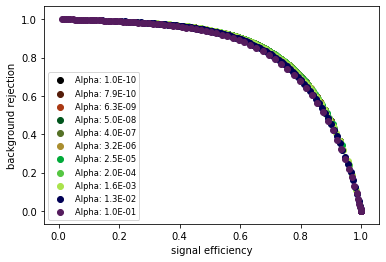

In [11]:
alphas = np.logspace(-10,-1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it = 0



for alpha in alphas:
    print("Training for alpha = %.2E"%alpha)
    c1 = 1.*(float(it)%3.)/3.0
    c2 = 1.*(float(it)%9.)/9.0
    c3 = 1.*(float(it)%27.)/27.0
    probsSimple, accep, rej = runTensorFlowRegression(8,alpha)
    ax.scatter(accep, rej, c=[[c1,c2,c3]], label='Alpha: %.1E' %alpha)
    it += 1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='best', fontsize='small')
plt.show()

	 Training with 15000 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-05 : 0.770
	 Computing ROV curve ...


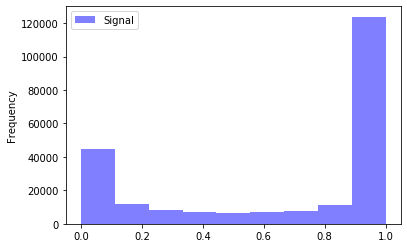

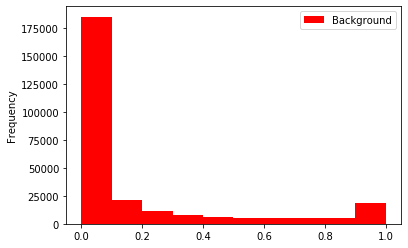

In [14]:
probsSimple,accep,rej = runTensorFlowRegression(8,0.00001)
Signal = df_test['signal'].values

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG'] = Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Training for alpha = 1.00E-10
	 Training with 15000 minibatches, dataset size is 1500000
	 Accuracy for alpha 1.0E-10 : 0.790
	 Computing ROV curve ...
Training for alpha = 7.94E-10
	 Training with 15000 minibatches, dataset size is 1500000
	 Accuracy for alpha 7.9E-10 : 0.790
	 Computing ROV curve ...
Training for alpha = 6.31E-09
	 Training with 15000 minibatches, dataset size is 1500000
	 Accuracy for alpha 6.3E-09 : 0.790
	 Computing ROV curve ...
Training for alpha = 5.01E-08
	 Training with 15000 minibatches, dataset size is 1500000
	 Accuracy for alpha 5.0E-08 : 0.790
	 Computing ROV curve ...
Training for alpha = 3.98E-07
	 Training with 15000 minibatches, dataset size is 1500000
	 Accuracy for alpha 4.0E-07 : 0.790
	 Computing ROV curve ...
Training for alpha = 3.16E-06
	 Training with 15000 minibatches, dataset size is 1500000
	 Accuracy for alpha 3.2E-06 : 0.790
	 Computing ROV curve ...
Training for alpha = 2.51E-05
	 Training with 15000 minibatches, dataset size is 1500000

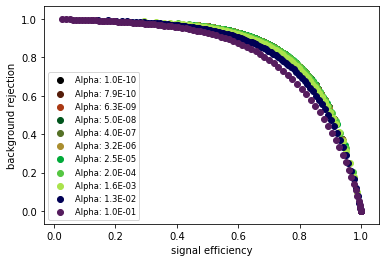

In [12]:
alphas = np.logspace(-10,-1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it = 0



for alpha in alphas:
    print("Training for alpha = %.2E"%alpha)
    c1 = 1.*(float(it)%3.)/3.0
    c2 = 1.*(float(it)%9.)/9.0
    c3 = 1.*(float(it)%27.)/27.0
    probsSimple, accep, rej = runTensorFlowRegression(18,alpha)
    ax.scatter(accep, rej, c=[[c1,c2,c3]], label='Alpha: %.1E' %alpha)
    it += 1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='best', fontsize='small')
plt.show()

### Try the same with scikit packages

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

def runSciKitRegressionL2(nVar,alpha):
    X_train, y_train = getTrainData(nVar)
    X_test, y_test   = getTestData(nVar)
    clf = SGDClassifier(loss='log',penalty='l2',alpha=alpha, max_iter=5, tol = None)
    clf.fit(X_train,y_train.ravel())
    predictions = clf.predict(X_test)
    
    print ('Accuracy on test data with alpha %.2E : %.3f'%(alpha,clf.score(X_test,y_test)))
    probs = clf.predict_proba(X_test)
    
    thresholds = np.arange(0,1,0.01)
    Acceptance, Rejection = build_roc_curve(probs, y_test, thresholds)
    return (probs, Acceptance, Rejection)

def runSciKitRegressionL1(nVar,alpha):
    X_train, y_train = getTrainData(nVar)
    X_test, y_test   = getTestData(nVar)
    clf = SGDClassifier(loss='log',penalty='l1',alpha=alpha, max_iter=5, tol = None)
    clf.fit(X_train,y_train.ravel())
    predictions = clf.predict(X_test)
    
    print ('Accuracy on test data with alpha %.2E : %.3f'%(alpha,clf.score(X_test,y_test)))
    probs = clf.predict_proba(X_test)
    
    thresholds = np.arange(0,1,0.01)
    Acceptance, Rejection = build_roc_curve(probs, y_test, thresholds)
    return (probs, Acceptance, Rejection)

Training for alpha = 1.00E-10
Accuracy on test data with alpha 1.00E-10 : 0.580
Training for alpha = 7.94E-10
Accuracy on test data with alpha 7.94E-10 : 0.651
Training for alpha = 6.31E-09
Accuracy on test data with alpha 6.31E-09 : 0.658
Training for alpha = 5.01E-08
Accuracy on test data with alpha 5.01E-08 : 0.677
Training for alpha = 3.98E-07
Accuracy on test data with alpha 3.98E-07 : 0.768
Training for alpha = 3.16E-06
Accuracy on test data with alpha 3.16E-06 : 0.762
Training for alpha = 2.51E-05
Accuracy on test data with alpha 2.51E-05 : 0.768
Training for alpha = 2.00E-04
Accuracy on test data with alpha 2.00E-04 : 0.768
Training for alpha = 1.58E-03
Accuracy on test data with alpha 1.58E-03 : 0.768
Training for alpha = 1.26E-02
Accuracy on test data with alpha 1.26E-02 : 0.765
Training for alpha = 1.00E-01
Accuracy on test data with alpha 1.00E-01 : 0.720


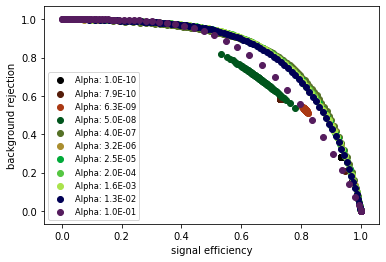

In [16]:
alphas = np.logspace(-10,-1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it = 0



for alpha in alphas:
    print("Training for alpha = %.2E"%alpha)
    c1 = 1.*(float(it)%3.)/3.0
    c2 = 1.*(float(it)%9.)/9.0
    c3 = 1.*(float(it)%27.)/27.0
    probsSimple, accep, rej = runSciKitRegressionL1(8,alpha)
    ax.scatter(accep, rej, c=[[c1,c2,c3]], label='Alpha: %.1E' %alpha)
    it += 1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='best', fontsize='small')
plt.show()

Training for alpha = 1.00E-10
Accuracy on test data with alpha 1.00E-10 : 0.769
Training for alpha = 7.94E-10
Accuracy on test data with alpha 7.94E-10 : 0.655
Training for alpha = 6.31E-09
Accuracy on test data with alpha 6.31E-09 : 0.652
Training for alpha = 5.01E-08
Accuracy on test data with alpha 5.01E-08 : 0.711
Training for alpha = 3.98E-07
Accuracy on test data with alpha 3.98E-07 : 0.783
Training for alpha = 3.16E-06
Accuracy on test data with alpha 3.16E-06 : 0.789
Training for alpha = 2.51E-05
Accuracy on test data with alpha 2.51E-05 : 0.788
Training for alpha = 2.00E-04
Accuracy on test data with alpha 2.00E-04 : 0.789
Training for alpha = 1.58E-03
Accuracy on test data with alpha 1.58E-03 : 0.788
Training for alpha = 1.26E-02
Accuracy on test data with alpha 1.26E-02 : 0.776
Training for alpha = 1.00E-01
Accuracy on test data with alpha 1.00E-01 : 0.715


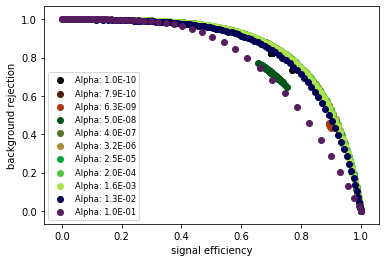

In [17]:
alphas = np.logspace(-10,-1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it = 0



for alpha in alphas:
    print("Training for alpha = %.2E"%alpha)
    c1 = 1.*(float(it)%3.)/3.0
    c2 = 1.*(float(it)%9.)/9.0
    c3 = 1.*(float(it)%27.)/27.0
    probsSimple, accep, rej = runSciKitRegressionL1(18,alpha)
    ax.scatter(accep, rej, c=[[c1,c2,c3]], label='Alpha: %.1E' %alpha)
    it += 1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='best', fontsize='small')
plt.show()

Training for alpha = 1.00E-10
Accuracy on test data with alpha 1.00E-10 : 0.620
Training for alpha = 7.94E-10
Accuracy on test data with alpha 7.94E-10 : 0.685
Training for alpha = 6.31E-09
Accuracy on test data with alpha 6.31E-09 : 0.676
Training for alpha = 5.01E-08
Accuracy on test data with alpha 5.01E-08 : 0.707
Training for alpha = 3.98E-07
Accuracy on test data with alpha 3.98E-07 : 0.757
Training for alpha = 3.16E-06
Accuracy on test data with alpha 3.16E-06 : 0.756
Training for alpha = 2.51E-05
Accuracy on test data with alpha 2.51E-05 : 0.766
Training for alpha = 2.00E-04
Accuracy on test data with alpha 2.00E-04 : 0.768
Training for alpha = 1.58E-03
Accuracy on test data with alpha 1.58E-03 : 0.768
Training for alpha = 1.26E-02
Accuracy on test data with alpha 1.26E-02 : 0.766
Training for alpha = 1.00E-01
Accuracy on test data with alpha 1.00E-01 : 0.752


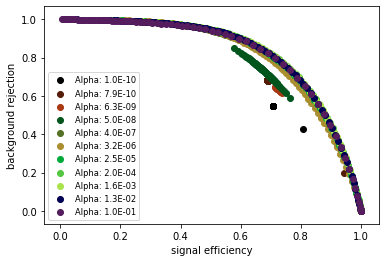

In [18]:
alphas = np.logspace(-10,-1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it = 0



for alpha in alphas:
    print("Training for alpha = %.2E"%alpha)
    c1 = 1.*(float(it)%3.)/3.0
    c2 = 1.*(float(it)%9.)/9.0
    c3 = 1.*(float(it)%27.)/27.0
    probsSimple, accep, rej = runSciKitRegressionL2(8,alpha)
    ax.scatter(accep, rej, c=[[c1,c2,c3]], label='Alpha: %.1E' %alpha)
    it += 1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='best', fontsize='small')
plt.show()

Training for alpha = 1.00E-10
Accuracy on test data with alpha 1.00E-10 : 0.710
Training for alpha = 7.94E-10
Accuracy on test data with alpha 7.94E-10 : 0.657
Training for alpha = 6.31E-09
Accuracy on test data with alpha 6.31E-09 : 0.668
Training for alpha = 5.01E-08
Accuracy on test data with alpha 5.01E-08 : 0.754
Training for alpha = 3.98E-07
Accuracy on test data with alpha 3.98E-07 : 0.730
Training for alpha = 3.16E-06
Accuracy on test data with alpha 3.16E-06 : 0.778
Training for alpha = 2.51E-05
Accuracy on test data with alpha 2.51E-05 : 0.787
Training for alpha = 2.00E-04
Accuracy on test data with alpha 2.00E-04 : 0.789
Training for alpha = 1.58E-03
Accuracy on test data with alpha 1.58E-03 : 0.788
Training for alpha = 1.26E-02
Accuracy on test data with alpha 1.26E-02 : 0.779
Training for alpha = 1.00E-01
Accuracy on test data with alpha 1.00E-01 : 0.755


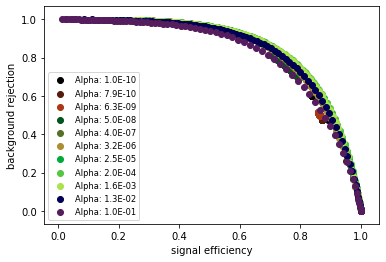

In [19]:
alphas = np.logspace(-10,-1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it = 0



for alpha in alphas:
    print("Training for alpha = %.2E"%alpha)
    c1 = 1.*(float(it)%3.)/3.0
    c2 = 1.*(float(it)%9.)/9.0
    c3 = 1.*(float(it)%27.)/27.0
    probsSimple, accep, rej = runSciKitRegressionL2(18,alpha)
    ax.scatter(accep, rej, c=[[c1,c2,c3]], label='Alpha: %.1E' %alpha)
    it += 1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='best', fontsize='small')
plt.show()

Accuracy on test data with alpha 1.00E-05 : 0.767


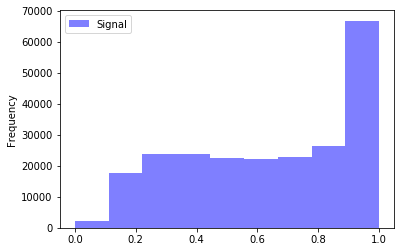

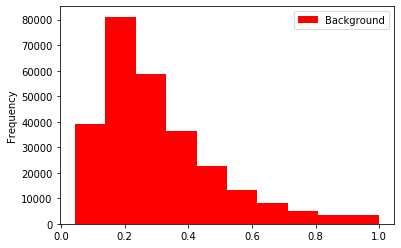

In [22]:
probsSimple,accep,rej = runSciKitRegressionL2(8,0.00001)
Signal = df_test['signal'].values

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG'] = Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Accuracy on test data with alpha 1.00E-05 : 0.789


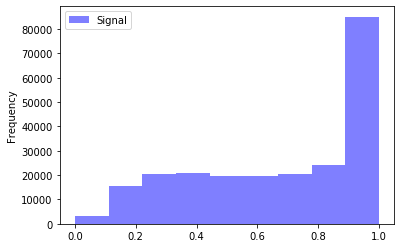

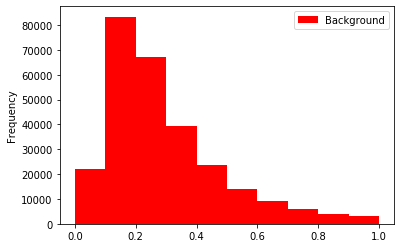

In [23]:
probsSimple,accep,rej = runSciKitRegressionL2(18,0.00001)
Signal = df_test['signal'].values

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG'] = Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Accuracy on test data with alpha 1.00E-05 : 0.766


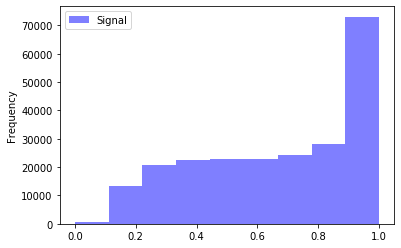

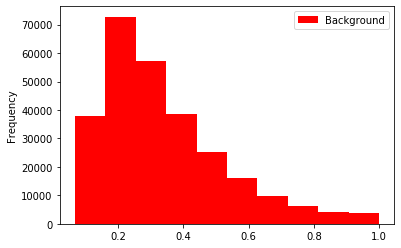

In [24]:
probsSimple,accep,rej = runSciKitRegressionL1(8,0.00001)
Signal = df_test['signal'].values

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG'] = Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Accuracy on test data with alpha 1.00E-05 : 0.767


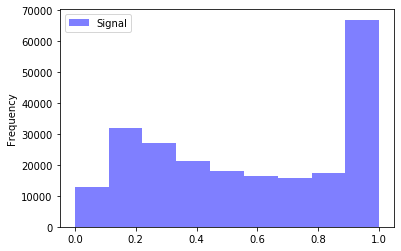

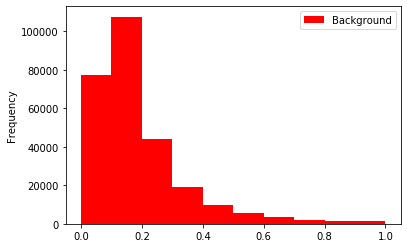

In [25]:
probsSimple,accep,rej = runSciKitRegressionL1(18,0.00001)
Signal = df_test['signal'].values

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG'] = Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')